# Testing trained RL agents

In [1]:
import tensorflow as tf
import configparser
import numpy as np
import os
print(tf.__version__)
from drl_grams import *

2025-06-12 15:28:36.132631: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.12.0


In [2]:

# Load the RL model from the directory
directory = "optuna_drl/opt_for_n8_oaps_noise_per/trial_5"
# Find the config file in the directory

for file in os.listdir(directory):
    if file.endswith(".ini"):
        config_file = file
        break
    
config = configparser.ConfigParser()
# Read the config file
config.read(directory + "/" + config_file)

# Copy the config file to the current directory
current_directory = os.getcwd()
os.system(f"cp {directory}/{config_file} {current_directory}")


checkpoint_prefix = directory+'/final_model/model.ckpt'

# Load the model from the checkpoint
with tf.compat.v1.Session() as sess:
    # Restore the graph structure from the .meta file
    saver = tf.compat.v1.train.import_meta_graph(checkpoint_prefix + ".meta")
    
    # Restore the weights from the checkpoint
    saver.restore(sess, checkpoint_prefix)
    
    
    # The model is now loaded into the session
    print("Model restored successfully!")

2025-06-12 15:28:41.835484: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


INFO:tensorflow:Restoring parameters from optuna_drl/opt_for_n8_oaps_noise_per/trial_5/final_model/model.ckpt
Model restored successfully!


2025-06-12 15:28:42.152934: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


In [3]:
from state_env import State  # module with environment and dynamics

from RL_brain_pi_deep import DQNPrioritizedReplay  # sumtree version of DQN

Instructions for updating:
non-resource variables are not supported in the long term
Seed used: 1749752922


In [ ]:

env = State()  # environment

In [ ]:

# Inspect the graph to find input and output tensor names
for op in tf.compat.v1.get_default_graph().get_operations():
    print(op.name)

s
Q_target
IS_weights
eval_net/l1/w1/Initializer/random_normal/shape
eval_net/l1/w1/Initializer/random_normal/mean
eval_net/l1/w1/Initializer/random_normal/stddev
eval_net/l1/w1/Initializer/random_normal/RandomStandardNormal
eval_net/l1/w1/Initializer/random_normal/mul
eval_net/l1/w1/Initializer/random_normal
eval_net/l1/w1
eval_net/l1/w1/Assign
eval_net/l1/w1/read
eval_net/l1/b1/Initializer/Const
eval_net/l1/b1
eval_net/l1/b1/Assign
eval_net/l1/b1/read
eval_net/l1/MatMul
eval_net/l1/add
eval_net/l1/Relu
eval_net/l15/w15/Initializer/random_normal/shape
eval_net/l15/w15/Initializer/random_normal/mean
eval_net/l15/w15/Initializer/random_normal/stddev
eval_net/l15/w15/Initializer/random_normal/RandomStandardNormal
eval_net/l15/w15/Initializer/random_normal/mul
eval_net/l15/w15/Initializer/random_normal
eval_net/l15/w15
eval_net/l15/w15/Assign
eval_net/l15/w15/read
eval_net/l15/b15/Initializer/Const
eval_net/l15/b15
eval_net/l15/b15/Assign
eval_net/l15/b15/read
eval_net/l15/MatMul
eval_net

In [ ]:
input_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name("s:0")
output_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name("eval_net/l2/add:0")
n = 8

In [ ]:
with tf.compat.v1.Session() as sess:
    # Restore the graph structure and weights again
    saver.restore(sess, checkpoint_prefix)

    number_of_episodes = 100
    lth = config.getint(
            "system_parameters", "max_t_steps"
        )
    
    print("max_t_steps: ", lth)

    best_action_sequences = [[] for i in range(0, 10)]
    best_fidelities = np.zeros(10)

    actionspace = []  # store successful actions
    Qvalue = []  # total reward
    fid_max_vector = []  # max. fidelity in each episode
    t_fid_max_vector = []  # time of max. fidelity
    fid_end_vector = []  # final fidelity
    t_end_vector = []  # time of final fidelity
    success_action_sequences = []  # store successful success_action_seq

    for episode in range(number_of_episodes):
        # Generate a complex normalized vector of 16 components
        observation = env.reset()
        
        newaction = []
        Q = 0
        fid_max = 0
        t_fid_max = 0

        for i in range(lth):  # episode maximum length
            # Use the loaded model to predict the action
            # Correct the shape of the observation before feeding it to the model
            predicted_action = sess.run(output_tensor, feed_dict={input_tensor: np.expand_dims(observation, axis=0)})
            predicted_action = np.argmax(predicted_action)
            newaction.append(predicted_action)

            observation_, reward, done, fidelity = env.noisy_step(predicted_action,0.25,0.5)
            #fidelity = np.sqrt(observation_[-1]**2+observation_[-2]**2)  # Calculate fidelity from the last two components of the observation
            #print("reward: ", reward , " fidelity: ", fidelity)
            Q += reward  # total reward
        

            # Save max. fidelity value
            if fidelity > fid_max:
                fid_max = fidelity
                t_fid_max = i

            if done:  # fidelity(reward) larger than threshold
                newaction += [0 for xx in range(lth - len(newaction))]
                print(str(i + 1) + "  " + str(episode) + "  " + str(fidelity))
                actionspace.append(newaction)
                Qvalue.append(Q)
                fid_max_vector.append(fid_max)
                fid_end_vector.append(fidelity)
                t_fid_max_vector.append(t_fid_max)
                t_end_vector.append(i + 1)

                if fid_max > 0.9:
                    success_action_sequences.append(newaction)

                    break

            observation = observation_  # Update current state

        if i == lth - 1:
            actionspace.append(newaction)
            fid_max_vector.append(fid_max)
            fid_end_vector.append(fidelity)
            t_fid_max_vector.append(t_fid_max)
            t_end_vector.append(i + 1)
            Qvalue.append(Q)

            if fid_max > 0.9:
                success_action_sequences.append(newaction)

        if fid_max > min(best_fidelities):
            idx = np.argmin(best_fidelities)
            best_fidelities[idx] = fid_max
            best_action_sequences[idx] = newaction

        print(
            "Episode: %d, Step: %d, Max. Fidelity: %.4f"
            % (episode, i, fid_max)
        )
        episodes = np.arange(0, number_of_episodes)

    print("Mean of fid_max_vector:", np.mean(fid_max_vector))

INFO:tensorflow:Restoring parameters from optuna_drl/opt_for_n8_oaps_noise_per/trial_5/final_model/model.ckpt
max_t_steps:  40
Episode: 0, Step: 39, Max. Fidelity: 0.0005
Episode: 1, Step: 39, Max. Fidelity: 0.0006
Episode: 2, Step: 39, Max. Fidelity: 0.0003
Episode: 3, Step: 39, Max. Fidelity: 0.0002
Episode: 4, Step: 39, Max. Fidelity: 0.0003
Episode: 5, Step: 39, Max. Fidelity: 0.0003
Episode: 6, Step: 39, Max. Fidelity: 0.0002
Episode: 7, Step: 39, Max. Fidelity: 0.0003
Episode: 8, Step: 39, Max. Fidelity: 0.0000
Episode: 9, Step: 39, Max. Fidelity: 0.0000
Episode: 10, Step: 39, Max. Fidelity: 0.0000
Episode: 11, Step: 39, Max. Fidelity: 0.0003
Episode: 12, Step: 39, Max. Fidelity: 0.0004
Episode: 13, Step: 39, Max. Fidelity: 0.0005
Episode: 14, Step: 39, Max. Fidelity: 0.0003
Episode: 15, Step: 39, Max. Fidelity: 0.0001
Episode: 16, Step: 39, Max. Fidelity: 0.0001
Episode: 17, Step: 39, Max. Fidelity: 0.0002
Episode: 18, Step: 39, Max. Fidelity: 0.0002
Episode: 19, Step: 39, Max. 

In [ ]:
print("Mean of fid_max_vector:", np.mean(fid_max_vector))

Mean of fid_max_vector: 0.9218946610721153


Best action sequence: [10, 10, 10, 10, 10, 10, 10, 10, 7, 8, 8, 10, 10, 1, 8, 1, 10, 10, 10, 2, 9, 2, 10, 3, 10, 10, 2, 0, 4, 4, 3, 3, 3, 3, 3, 3, 6, 6, 2, 6, 2, 10, 9, 11, 8, 2, 6, 6, 0, 0, 0, 0, 0, 0, 0]
Best action sequence: [10, 10, 10, 10, 10, 10, 10, 10, 7, 7, 0, 10, 10, 8, 1, 9, 10, 10, 10, 2, 9, 10, 10, 10, 3, 10, 11, 0, 4, 4, 4, 4, 4, 4, 4, 2, 6, 6, 6, 2, 2, 10, 9, 11, 8, 2, 6, 6, 0, 0, 0, 0, 0, 0, 0]
Best action sequence: [10, 10, 10, 10, 10, 10, 8, 8, 7, 7, 9, 9, 10, 1, 10, 1, 10, 10, 10, 2, 9, 10, 10, 10, 3, 1, 11, 4, 4, 4, 1, 1, 1, 1, 1, 1, 2, 6, 6, 6, 2, 10, 9, 11, 8, 2, 6, 6, 0, 0, 0, 0, 0, 0, 0]
Best action sequence: [10, 10, 10, 10, 10, 10, 10, 8, 7, 7, 9, 9, 10, 1, 8, 1, 9, 10, 10, 10, 10, 2, 9, 10, 10, 10, 11, 4, 4, 1, 1, 1, 1, 1, 1, 1, 4, 2, 6, 6, 2, 10, 9, 11, 8, 8, 6, 6, 8, 0, 0, 0, 0, 0, 0]
Best action sequence: [10, 10, 10, 10, 10, 10, 10, 8, 7, 7, 8, 8, 8, 1, 8, 1, 11, 11, 2, 2, 9, 11, 11, 3, 10, 10, 11, 2, 4, 3, 3, 3, 3, 3, 4, 3, 3, 6, 3, 2, 2, 10, 9, 11, 8, 2

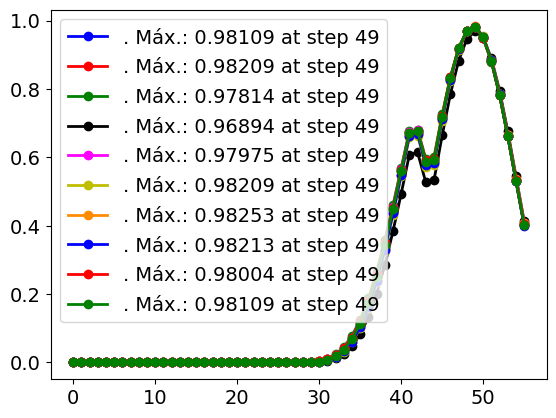

In [ ]:
for sequence in best_action_sequences:
    print("Best action sequence:", sequence)
    plot_single_sequence(sequence,11,0.15,100, actions='oaps')

INFO:tensorflow:Restoring parameters from drl_results/trial_5/final_model/model.ckpt


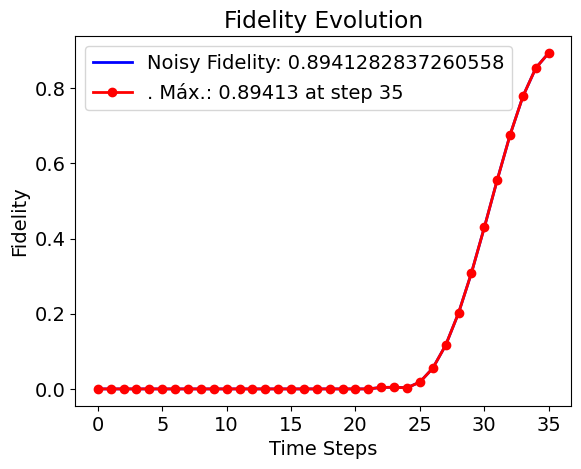

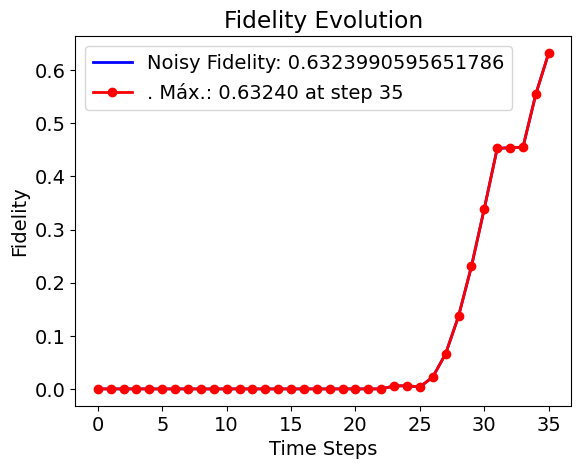

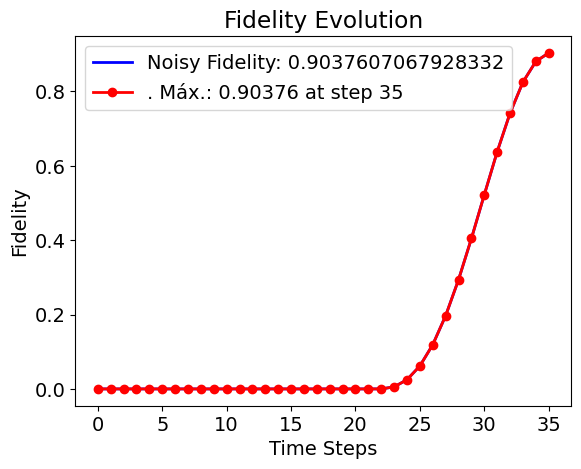

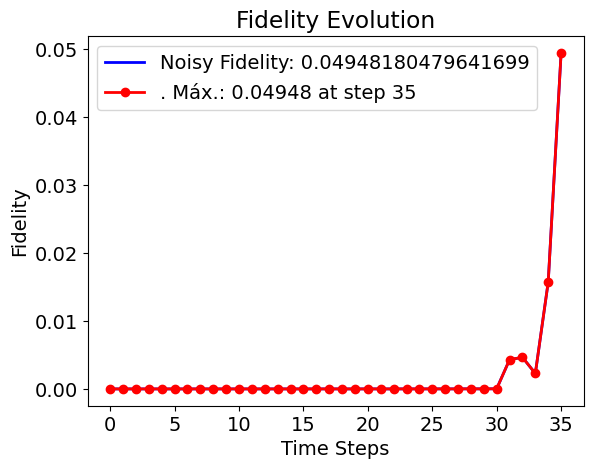

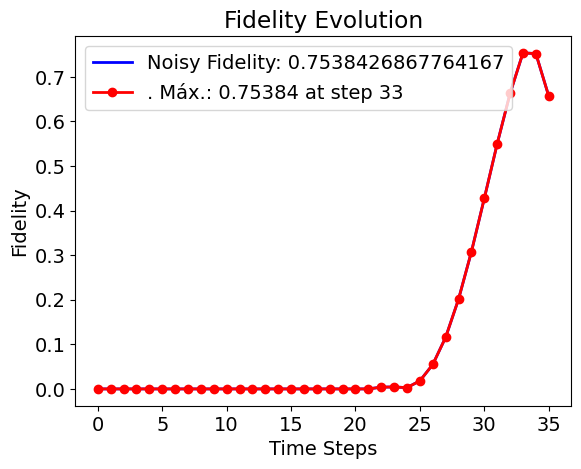

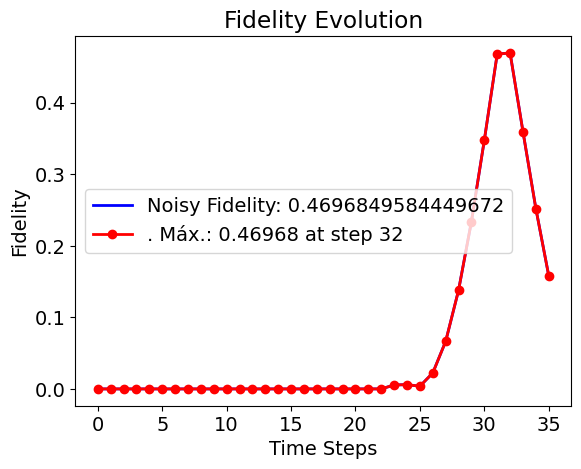

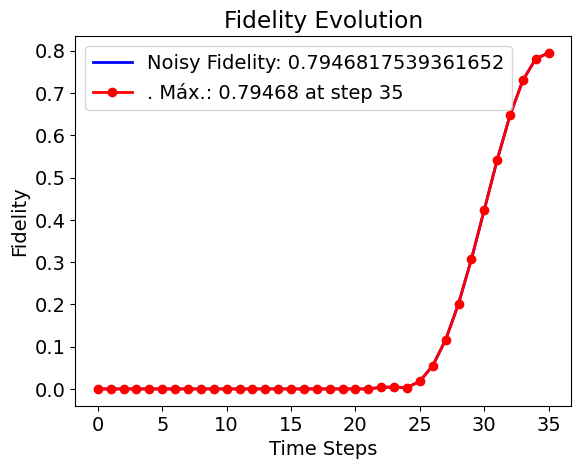

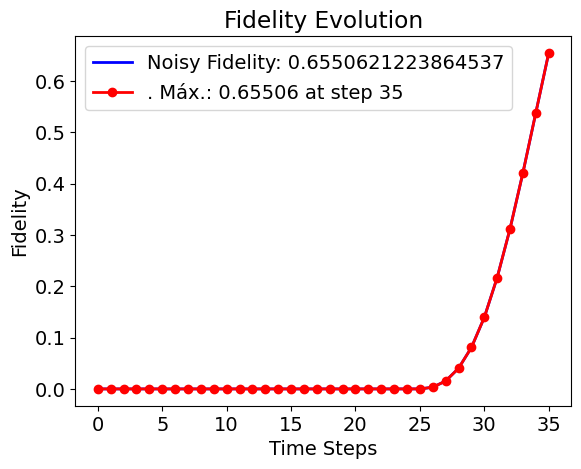

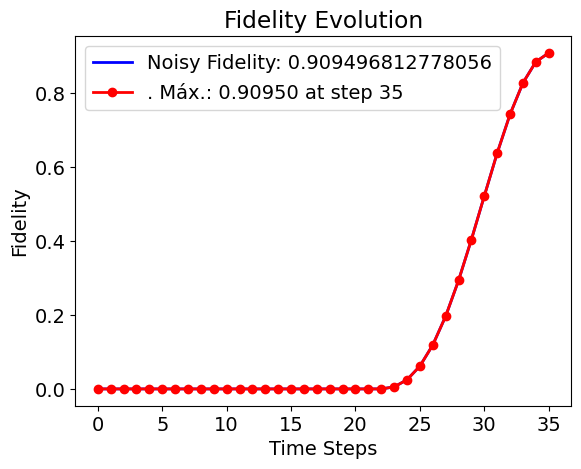

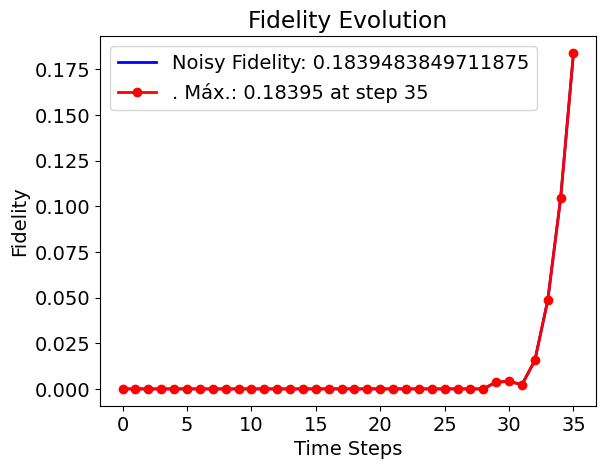

Mean of fid_max_vector: 0.49002941436039776


In [ ]:
env = State()  # environment
env2 = State()  # environment


with tf.compat.v1.Session() as sess:
    # Restore the graph structure and weights again
    saver.restore(sess, checkpoint_prefix)

    lth = config.getint(
            "system_parameters", "max_t_steps"
        )
    number_of_episodes = 10


    # actionspace = []  # store successful actions
    # Qvalue = []  # total reward
    # fid_max_vector = []  # max. fidelity in each episode
    # t_fid_max_vector = []  # time of max. fidelity
    # fid_end_vector = []  # final fidelity
    # t_end_vector = []  # time of final fidelity
    # success_action_sequences = []  # store successful success_action_seq

    for episode in range(number_of_episodes):
        
        env2 = State()  # environment

        # Generate a complex normalized vector of 16 components
        noisy_observation = env2.reset()
        
        ideal_evolution = [0]
        noisy_evolution = [0]

        newaction = []
    
        for i in range(lth):  # episode maximum length
            # Use the loaded model to predict the action
            # Correct the shape of the observation before feeding it to the model
            predicted_action = sess.run(output_tensor, feed_dict={input_tensor: np.expand_dims(noisy_observation, axis=0)})
            predicted_action = np.argmax(predicted_action)
            newaction.append(predicted_action)

            noisy_observation_, noisy_reward, noisy_done, noisy_fidelity2 = env2.noisy_step(predicted_action)   

            noisy_fidelity = noisy_observation_[13]**2 + noisy_observation_[12]**2

            noisy_observation = noisy_observation_
            noisy_evolution.append(noisy_fidelity)
        
       
      
        plt.plot(noisy_evolution, label = 'Noisy Fidelity: {}'.format(np.max(noisy_evolution)))
        plot_single_sequence(newaction,7,0.15,100, actions='oaps')
        plt.xlabel('Time Steps')
        plt.ylabel('Fidelity')
        plt.title('Fidelity Evolution')
        plt.legend()
        plt.show()


    print("Mean of fid_max_vector:", np.mean(fid_max_vector))